# Parking Ticket Price Prediction
# Capstone Project
## Step2
## Advanced Modelling

### Alla B.
Email: allaboyers@gmail.com

### November 26, 2023

### Table of Contents
1. [Overview](#Overview)
2. [Importing Libraries](#Importing-Libraries)
3. [Modelling](#Modelling)
4. [SUMMARY:](#SUMMARY:)

## Overview

Parking tickets across the city generate millions in revenue for the City of Toronto every year. Even though the City of Toronto's revenue from parking tickets has gone up slightly in the last 2-3 years, after Covid-19, it has been declining since 2019. There is an opportunity to reverse this decline by making the City of Toronto's Administrative Penalty System (APS) more efficient. Using machine learning can enhance the efficiency of the APS.The impact of an efficient model can make the city safer and more attractive to residents and tourists. 

Refer to Step1_EDA_and_Baseline_Modelling.ipynb for data explanation, EDA and baseline modelling.

## Importing Libraries

In [52]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os #to read file paths
import warnings
warnings.filterwarnings("ignore")
import json
from IPython.display import display

In [53]:
# reading the clean data 
df_clean = pd.read_csv("full_data.csv")

In [55]:
# check first 5 rows
df_clean.head()

,set_fine_amount,hour,min,Day,Month,Year,latitude,longitude
0,30,0,5,1,1,2020,43.792145,-79.234291
1,30,18,6,2,1,2020,43.792145,-79.234291
2,30,18,8,2,1,2020,43.792145,-79.234291
3,30,18,9,2,1,2020,43.792145,-79.234291
4,30,4,14,8,1,2020,43.792145,-79.234291


## Modelling

In [59]:
# repeat some steps from previous notebook to prepare the dataset for the advanced modelling
# check fine amount counts
df_clean["set_fine_amount"].value_counts()

set_fine_amount
30     1178716
100     290626
50      156322
75       82374
40       71991
150      48983
450      21196
250      16459
60       16051
0          546
300        250
55          68
90          51
15          15
200          5
Name: count, dtype: int64

In [57]:
# pick frequent fine amounts
freq_count_set_fine_amount = df_clean["set_fine_amount"].value_counts()
dfs = []

for CLASS, count in zip(freq_count_set_fine_amount.index, freq_count_set_fine_amount.values):
    if count >= 16000:
        df_temp = df_clean[df_clean['set_fine_amount'] == CLASS].iloc[:16000]
        dfs.append(df_temp)
    
# ref: https://www.dataquest.io/blog/tutorial-advanced-for-loops-python-pandas/
# https://www.techversantinfotech.com/python-naming-conventions-points-you-should-know

In [58]:
# concatenate dfs
df_balance = pd.concat(dfs)
df_balance['set_fine_amount'].value_counts()


set_fine_amount
30     16000
100    16000
50     16000
75     16000
40     16000
150    16000
450    16000
250    16000
60     16000
Name: count, dtype: int64

In [60]:
# pull out the X and y

X = df_balance.drop('set_fine_amount', axis = 1)
y = df_balance['set_fine_amount']


In [61]:
# transform the labels into the expected XGBoost format

replace_dict = {30: 0, 40: 1, 50: 2, 60: 3, 75: 4, 100: 5, 150: 6, 250: 7, 450: 8}
y = y.replace(replace_dict)

In [62]:
# Train-Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [63]:
## finding the best set of Hyperparameters

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

model = XGBClassifier() 

# defining the param_grid, by keeping the 4 hyperparameeters namely

# n_estimators – Number of boosting rounds
# max_depth – Maximum tree depth for base learners
# colsample_bytree – Subsample ratio of columns when constructing each tree
# learning_rate – Boosting learning rate

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth':[2, 4, 6],
    'colsample_bytree': [0.5, 1.0],
    'n_estimators': [64, 128, 256],
}

# taking a sample of training data to run GridSearchCV faster
X_tune = X_train[:500]
y_tune = y_train[:500]

# executing the GridSearchCV with the XGBClassifier estimator and the provided param_grid. 
# I've set cv = 2 to reduce the cross-validation splits, as the default value was 5.
# This adjustment is made to expedite the process due to longer loading times.

gs = GridSearchCV(model,param_grid, cv = 2)
gs.fit(X_tune,y_tune)
gs.best_params_


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 128}

In [64]:
# training the model on the best set of Parameters

best_params = gs.best_params_
model = XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=128, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [65]:
# creating Classification Report

from  sklearn.metrics import classification_report
y_pred = model.predict(X_test)
report =  classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3183
           1       0.89      0.89      0.89      3152
           2       0.82      0.86      0.84      3268
           3       0.93      0.93      0.93      3121
           4       0.99      1.00      0.99      3220
           5       0.89      0.83      0.86      3230
           6       0.90      0.84      0.87      3221
           7       0.87      0.93      0.90      3256
           8       0.90      0.81      0.85      3149

    accuracy                           0.90     28800
   macro avg       0.90      0.90      0.90     28800
weighted avg       0.90      0.90      0.90     28800



**After examining the classification report, I observed that the model is well-generalized, achieving a high overall accuracy of 90%. The F1 scores suggest that the model is not biased toward any specific class, demonstrating generalization across all classes.**

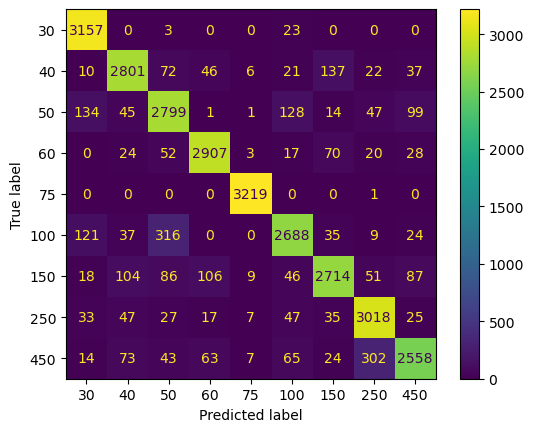

In [66]:
## Creating Confusion Matrix 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

# creating the  confusion matrix
cm = confusion_matrix(y_test, y_pred)

# dictionary to Decode the labels
inverse_replace_dic = {0: 30, 1: 40, 2: 50, 3: 60, 4: 75, 5: 100, 6: 150, 7: 250, 8: 450}

# decoding the  labels
display_labels = [inverse_replace_dic[cls] for cls  in model.classes_ ]

# displayig the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=display_labels)
disp.plot()
plt.show()

#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

**We can observe from the Confusion Matrix that the overall performance of each class is good, however poor performance is observed for class `100` and `450`.**

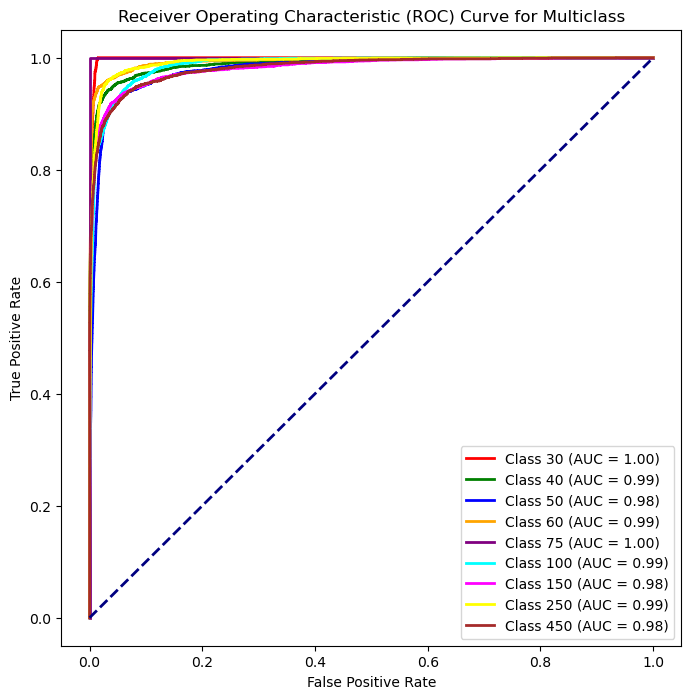

In [67]:
# import libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc



# binarize the labels
y_test_bin = label_binarize(y_test, classes=np.unique(y))

# get predicted probabilities for each class
y_score = model.predict_proba(X_test)

# compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(model.classes_.shape[0]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curve for each class
plt.figure(figsize=(8, 8))
colors = ['red', 'green', 'blue', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown']
 # customize colors based on the number of classes
for i, cls, color in zip(range(model.classes_.shape[0]), display_labels, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {cls} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multiclass')
plt.legend(loc='lower right')
plt.show()


**The above ROC Curve shows that each class has high sesitivity (True Positive Rate), which indicates that the model is good at identifying positive cases. It suggests that our model is effective in recognizing instances belonging to the positive class across all categories.**

Lastly, I will save the model to .pkl file.

In [69]:
# import pickle and save the model
import pickle
with open("model.pkl", "rb") as file:
    model1 = pickle.load(file)

### SUMMARY:

The model performs good with overall accuracy of 90%. The accuracy of positive predictions is high for all classes, with the highest of 99% for class 75. Recall is also high overall with the highest of 0.99 for class 30. The model identified 99% of the actual instances belonging to class 30. 
In summary, the model demonstrates good overall performance with balanced precision, recall, and F1-scores across multiple classes, resulting in a high accuracy of 90%.